In [86]:
import subprocess

def run_cmd(command, verbose=False):
    try:
        # Execute the command in the command prompt and capture the output
        result = subprocess.run(command, shell=True, capture_output=True, text=True)

        # Check if the command was successful
        if result.returncode == 0:
            if verbose: print(result.stdout)
            return result.stdout
        else:
            print(f"Command failed with return code {result.returncode}.")
            print("Error:")
            print(result.stderr)
            return ''
    
    except Exception as e:
        print(f"Error occurred: {e}")
        return ''

In [87]:
run_cmd("~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=0 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar -l")

'avrora batik eclipse fop h2 jython luindex lusearch lusearch-fix pmd sunflow tomcat tradebeans tradesoap xalan\nMy log: initialize /tmp/fileXaqio7, this=0x7fc3400789a0 with dump_freq=0\n'

In [88]:
# Functional workloads
dacapo_workloads = ['sunflow', 'pmd', 'avrora', 'fop', 'luindex', 'lusearch', 'lusearch-fix']

# Commands to run
# ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=0 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow
# ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=0 -jar ~/research_jvm/benchmarks/renaissance-gpl-0.14.2.jar -r 1 future-genetic

In [89]:
# run_cmd("~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=10 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow")

In [90]:
# run_cmd("find /tmp/ -maxdepth 1 -size +100b -type f -name 'file*' -exec ls -lth {} + | awk '{print $NF}'")

In [1]:
# logs reader

import datetime
import os
import sys

class ObjectCnt:
    def __init__(self, **kwargs) -> None:
        self.age = 0
        self.__dict__.update(kwargs)

    def __repr__(self):
        return "ObjectCnt(thread=%d, cls=%s, ptr='%s', cnt=%d, %s, size=%d, typ='%s', age=%d)" % (
            self.thread,
            self.cls,
            self.ptr,
            self.cnt,
            '' if self.length is None else ('length=%d' % self.length),
            self.size,
            self.typ,
            self.age
        )


def cur_timestamp():
    current_timestamp = datetime.datetime.now()
    return current_timestamp.strftime("%Y-%m-%d %H:%M:%S")


def reverse_readline(filename, buf_size=8192):
    with open(filename, 'r') as fh:
        segment = None
        offset = 0
        fh.seek(0, os.SEEK_END)
        file_size = remaining_size = fh.tell()
        while remaining_size > 0:
            offset = min(file_size, offset + buf_size)
            fh.seek(file_size - offset)
            buffer = fh.read(min(remaining_size, buf_size))
            remaining_size -= buf_size
            lines = buffer.split('\n')

            if segment is not None:
                if buffer[-1] != '\n': lines[-1] += segment
                else: yield segment
            
            segment = lines[0]
            for index in range(len(lines) - 1, 0, -1):
                if lines[index]:
                    yield lines[index]

        if segment is not None:
            yield segment


def read_line(filename):
    with open(filename, 'r') as file:
        for line in file:
            yield line


def add_snapshot(snapshots, snap, last_n):
    snapshots.append(snap)
    if last_n and len(snapshots) > last_n:
        snapshots = snapshots[1:]
    return snapshots


def count_number_of_dumps(logfile):
    snapshots_cnt = 0
    file_lines = reverse_readline(logfile)
    for line in file_lines:
        line = line.strip()
        if not line: continue

        if 'Dump Snapshot' in line:
            snapshots_cnt += 1

    return snapshots_cnt


def read_logs(logfile, last_n = None, verbose=False, reversed=False, generator=False):
    print(locals())
    if last_n is None: last_n = sys.maxsize
    snapshots = []
    cur_dict = set()
    snapshots_cnt = 0

    file_lines = reverse_readline(logfile) if reversed else read_line(logfile)
    for line in file_lines:
        line = line.strip()
        if not line: continue

        if 'Dump Snapshot' in line:
            if len(cur_dict) == 0: continue

            snapshots_cnt += 1

            if generator:
                if verbose:
                    idx = -snapshots_cnt if reversed else (snapshots_cnt - 1)
                    print('Snapshot #%d with size=%d' % (idx, len(cur_dict)))
                yield cur_dict
                if snapshots_cnt == last_n:
                    break
            else:
                snapshots = add_snapshot(snapshots, cur_dict, last_n)
                if reversed and len(snapshots) == last_n:
                    break
            
            cur_dict = set()
        elif 'Skipping Snapshot' not in line:
            # My log: th=172166293241342555, class=[B, ptr=0x60d1df368, cnt=64
            assert 'My log' in line, ('unexpected line format for ' + line)
            parts = line.split(', ')

            th_str = parts[0]
            if th_str.startswith('My log array:'): typ = 'array'
            elif th_str.startswith('My log obj:'): typ = 'object'
            else: assert False, ('unexpected log format for ' + th_str)

            cnt = int(parts[3][len('cnt='):])
            cnt, age = (cnt & 0x0FFFFFFF), (cnt >> 28)
            tup = ObjectCnt(
                thread = int(th_str[th_str.find('th=') + len('th='):]),
                cls = parts[1][len('class='):],
                ptr = parts[2][len('ptr='):],
                cnt = cnt,
                age = age,
                length = (None if typ == 'object' else int(parts[-2][len('len='):])),
                size = int(parts[-1][len('size='):]),
                typ = typ)
            
            cur_dict.add(tup)

    if len(cur_dict) > 0:
        if generator:
            if snapshots_cnt != last_n:
                snapshots_cnt += 1
                if verbose:
                    idx = -snapshots_cnt if reversed else (snapshots_cnt - 1)
                    print('Snapshot #%d with size=%d' % (idx, len(cur_dict)))
                yield cur_dict
        else:
            snapshots = add_snapshot(snapshots, cur_dict, last_n)

    if reversed and not generator:
        snapshots = snapshots[::-1]

    # print(snapshots)
    if verbose:
        print(cur_timestamp(), 'Got %d snapshots for the file=%s' % (snapshots_cnt, logfile))
        if not generator:
            for idx, snap in enumerate(snapshots):
                print('Snapshot #%d with size=%d' % (idx, len(snap)))

    if not generator:
        return snapshots

In [34]:
# logs/images saver

import matplotlib.backends.backend_pdf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

def display_freq_bins(objects, group_by_sizes=True, file=None, init_file=None, iteration=None, dynamic_bins_size=True):
    # Extract the access counts and sizes from the object counts
    objects = list(objects)
    access_counts = np.array([obj.cnt for obj in objects])
    object_sizes = np.array([obj.size for obj in objects])

    # Step 1: Create bins to group the access counts automatically
    num_bins = 10  # Adjust the number of bins as needed

    if dynamic_bins_size:
        # Calculate bin edges based on quantiles
        # lower_percentiles = np.linspace(0, 90, num_bins // 3 + 1)
        # higher_percentiles = np.linspace(90, 100, num_bins - (num_bins // 3))
        # bin_edges = np.percentile(access_counts, np.concatenate([lower_percentiles, higher_percentiles]))
        # bin_edges = np.percentile(access_counts, np.linspace(0, 100, num_bins + 1))
        _, bin_edges = pd.qcut(access_counts, q = num_bins, duplicates='drop', retbins=True)

        mask = (access_counts > bin_edges[-2]) & (access_counts <= bin_edges[-1])
        last_counts = access_counts[mask]

        _, extra_bin_edges = pd.qcut(last_counts, q = num_bins, duplicates='drop', retbins=True)
        bin_edges = list(bin_edges)[:-2] + list(extra_bin_edges)
        num_bins = len(bin_edges) - 1
    else:
        bin_edges = np.histogram_bin_edges(access_counts, bins=num_bins)

    # Step 2: Calculate the total size and object count for each bin
    total_sizes = np.zeros(num_bins, dtype=int)
    total_object_counts = np.zeros(num_bins, dtype=int)

    for i in range(num_bins):
        mask = (access_counts > bin_edges[i]) & (access_counts <= bin_edges[i + 1])

        total_sizes[i] = np.sum(object_sizes[mask])
        total_object_counts[i] = np.sum(mask)

    if group_by_sizes: y_axis = total_sizes
    else: y_axis = total_object_counts
    # print(y_axis)

    display_iteration = ' #' + str(iteration) if iteration is not None else ''

    # Step 3: Display the histogram
    plt.figure(figsize=(23, 6))  # Adjust figure size as needed
    plt.bar(range(num_bins), y_axis, width=0.8, align='center')
    plt.xlabel("Bins of Access Counts")
    if group_by_sizes: plt.ylabel("Size of Objects")
    else: plt.ylabel("Number of Objects")
    plt.title("Histogram of Objects by Access Counts %s" % display_iteration)
    plt.xticks(range(num_bins), [f"{int(bin_edges[i])}" for i in range(num_bins)])
    plt.grid(axis='y')
    plt.yscale('log')

    if init_file:
        file = matplotlib.backends.backend_pdf.PdfPages(init_file) # /tmp/output.pdf

    if file:
        file.savefig(plt.gcf())
        plt.close()
    else:
        plt.show()

    # Display the total number/size for each bin
    text_output = "Total stats for each bin %s:\n" % display_iteration
    text_output += f"Number of objects: ~{round(sum(total_object_counts)/1000, 2)} K\n"
    text_output += f"Size of objects: ~{round(sum(total_sizes)/(1024*1024), 2)} Mb\n"
    for i in range(num_bins):
        text_output += f"Bin {int(bin_edges[i])}-{int(bin_edges[i + 1])}: {round(total_object_counts[i]/1000, 2)}K objects, {round(total_sizes[i]/1024)} Kb\n"

        
    if file:
        plt.figure(figsize=(23, 6))
        plt.text(0.1, 0.5, text_output, fontsize=12, ha='left', va='center')
        plt.axis('off')

        file.savefig(plt.gcf())
        plt.close()

    else:
        print(text_output)

    # Step 4: Calculate proportion of objects with different ages in each bin
    ages = np.array([obj.age for obj in objects])
    age_groups = np.unique([obj.age for obj in objects])
    age_proportions = np.zeros((num_bins, len(age_groups)))

    for i in range(num_bins):
        # Calculate mask for each bin
        mask = (access_counts > bin_edges[i]) & (access_counts <= bin_edges[i + 1])

        # Apply mask to filter objects
        bin_ages = ages[mask]
        total_objects_in_bin = total_object_counts[i]  # Count of objects in this specific bin

        for j, age in enumerate(age_groups):
            age_count = np.sum(bin_ages == age)
            age_proportions[i, j] = (age_count / total_objects_in_bin) if total_objects_in_bin else 0

    # Step 5: Display the histogram with proportions of objects in age groups
    plt.figure(figsize=(23, 6))  # Adjust figure size as needed
    colors = plt.cm.get_cmap('tab20', len(age_groups))  # Choose a colormap

    bottom = np.zeros(num_bins)

    for j in range(len(age_groups)):
        plt.bar(range(num_bins), age_proportions[:, j], width=0.8, align='center', label=f'Age: {age_groups[j]}', color=colors(j), bottom=bottom)
        bottom += age_proportions[:, j]

    plt.xlabel("Bins of Access Counts")
    plt.ylabel("Proportion of Objects by Age Group")
    plt.title("Histogram of Objects by Access Counts %s" % display_iteration)
    plt.xticks(range(num_bins), [f"{int(bin_edges[i])}" for i in range(num_bins)])
    plt.grid(axis='y')
    plt.legend()

    if file:
        file.savefig(plt.gcf())
        plt.close()
    else:
        plt.show()

    # Print age proportions for each bin
    text_output = "Age proportions for each bin %s:\n" % display_iteration
    for i in range(num_bins):
        ages = [(age, round(age_proportions[i, j] * 100, 2)) for j, age in enumerate(age_groups) if age_proportions[i, j] != 0]
        ages.sort(key=lambda x: x[1], reverse=True)
        text_output += f"Bin {int(bin_edges[i])}-{int(bin_edges[i + 1])}, Age-Proportions: {ages}\n"

    if file:
        plt.figure(figsize=(23, 6))
        plt.text(0.1, 0.5, text_output, fontsize=12, ha='left', va='center')
        plt.axis('off')

        file.savefig(plt.gcf())
        plt.close()
        if init_file:
            file.close()

    else:
        print(text_output)


def replace_extension(file_path, new_extension):
    base_path, _ = os.path.splitext(file_path)
    new_file_path = base_path + new_extension
    return new_file_path


def process_store_dump(file, last_n, reversed=False):
    snapshots = read_logs(file, last_n=last_n, verbose=True)

    new_file_path = replace_extension(file, '.pdf')
    pdf = matplotlib.backends.backend_pdf.PdfPages(new_file_path)
    for idx, snap in enumerate(read_logs(file, last_n=last_n, verbose=True, generator=True, reversed=reversed)):
        if reversed: idx = - (idx + 1)
        display_freq_bins(snap, file=pdf, iteration=idx)
    pdf.close()
    return snapshots

In [7]:
file = '/home/hpylypets-ua/Documents/University/research_jvm/results/sunflow/run3/dump_filewrJoPj'
snapshots = read_logs(file, last_n=50, verbose=True)
# display_freq_bins(snapshots[1], init_file='/tmp/output.pdf')

2023-08-10 02:20:23 Got 15 snapshots for the file=/home/hpylypets-ua/Documents/University/research_jvm/results/sunflow/run3/dump_filewrJoPj
Snapshot #0 with size=23134
Snapshot #1 with size=188018
Snapshot #2 with size=217078
Snapshot #3 with size=219889
Snapshot #4 with size=218286
Snapshot #5 with size=231357
Snapshot #6 with size=232624
Snapshot #7 with size=235888
Snapshot #8 with size=237567
Snapshot #9 with size=230423
Snapshot #10 with size=225326
Snapshot #11 with size=230248
Snapshot #12 with size=159008
Snapshot #13 with size=134484
Snapshot #14 with size=59271


[0.00000000e+00 5.00000000e+00 1.00000000e+01 1.00000000e+01
 1.20000000e+01 1.30000000e+01 2.10000000e+01 2.40000000e+01
 5.50000000e+01 1.32000000e+02 4.21818659e+09]


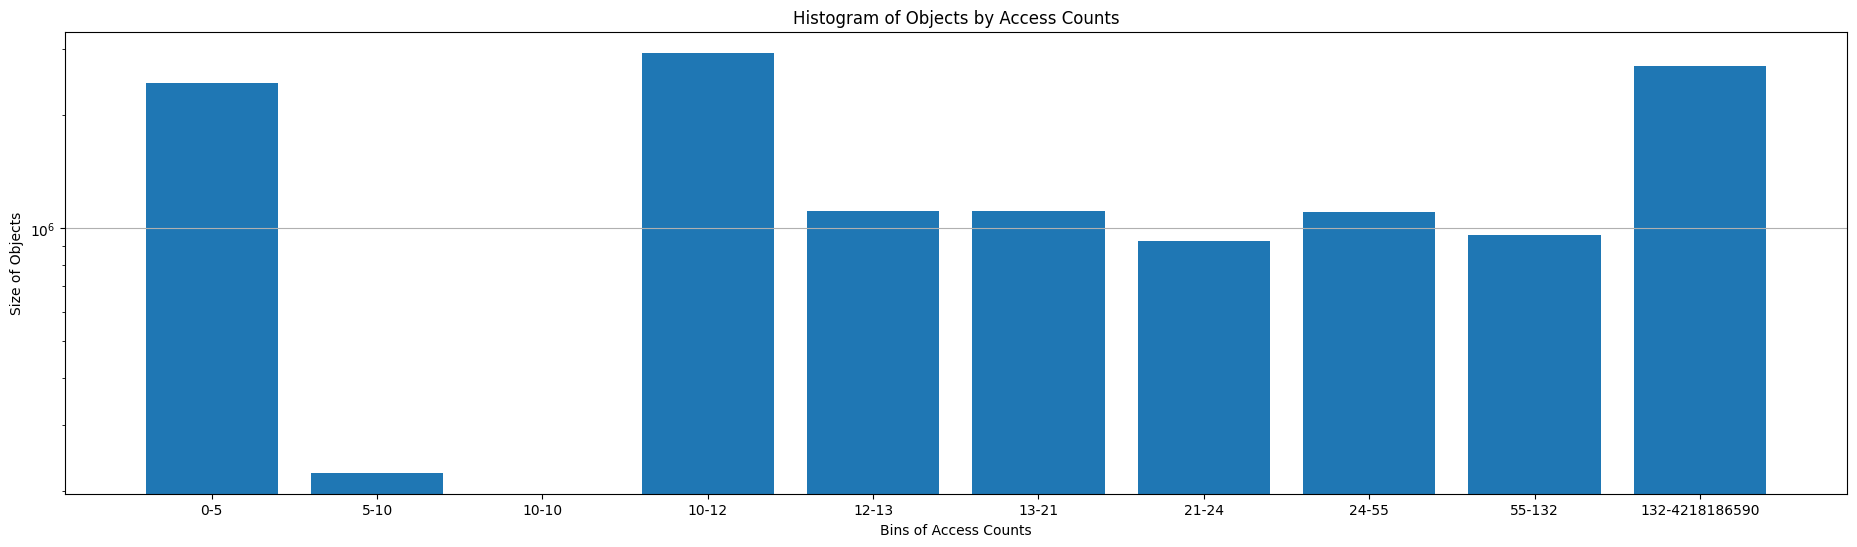

Total Number of Objects for Each Bin :
Bin 0-5: 22151 objects
Bin 5-10: 7152 objects
Bin 10-10: 0 objects
Bin 10-12: 52924 objects
Bin 12-13: 20285 objects
Bin 13-21: 20916 objects
Bin 21-24: 38260 objects
Bin 24-55: 23207 objects
Bin 55-132: 23177 objects
Bin 132-4218186590: 23284 objects



In [35]:
snap = snapshots[5]
display_freq_bins(snap)

In [94]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("/tmp/output.pdf")
# for idx, snap in enumerate(snapshots):
#     display_freq_bins(snap, file=pdf, iteration=idx)
# pdf.close()

In [102]:
# The flow

# Run workflow scenario - pick one of dacapo workloads and execute with run_cmd. let it be luindex
# Find files involved in GC stuff - find command with file_ greater than 100b
# Analyze each of the files to get a sequence of snapshots for each of which build a histogram of total object size for each access count bucket. Also, exclude anomaly data
# Store the results in the file in a format "benchmark/simulation/runX"
# Build for all the snapshots at this stage, but eventually we shouldn't pick more than 10
# Cleanup to remove the file* from /tmp

import os
import shutil
import subprocess

def run_cmd(command, verbose=False):
    try:
        # Execute the command in the command prompt and capture the output
        result = subprocess.run(command, shell=True, capture_output=True, text=True)

        # Check if the command was successful
        if result.returncode == 0:
            if verbose: print(result.stdout)
            return result.stdout
        else:
            print(f"Command failed with return code {result.returncode}.")
            print("Error:")
            print(result.stderr)
            return ''
    
    except Exception as e:
        print(f"Error occurred: {e}")
        return ''


OUTPUT_DIR = '/home/savitar/research_jvm/results/'


def file_is_dump(file):
    return os.path.getsize(file) > 100


def run_iteration(iter=0, run_benchmark=True, cleanup=True, last_n=100, dump_period=10, benchmark='luindex', copy_files=True):
    print(cur_timestamp(), 'Running iteration #{} with args={}'.format(iter, locals()))

    # cleanup
    if cleanup:
        print(cur_timestamp(), 'Cleanup')
        run_cmd("rm -f /tmp/file*")

    if not copy_files: run_benchmark = False
    
    if run_benchmark:
        cmd = f"~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq={dump_period} -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar {benchmark}" # sunflow
        print(cur_timestamp(), "Executing benchmark:", cmd)
        run_cmd(cmd)

    iteration_dir = os.path.join(OUTPUT_DIR, benchmark, 'run%d' % iter)

    if copy_files:
        if os.path.exists(iteration_dir):
            shutil.rmtree(iteration_dir)
        os.makedirs(iteration_dir)

        # copy all files first
        print(cur_timestamp(), 'Copying all the files to the %s' % iteration_dir)
        found_files = run_cmd("find /tmp/ -maxdepth 1 -type f -name 'file*' -exec ls -lth {} + | awk '{print $NF}'")
        copied_dump_files = []
        if found_files:
            found_files = found_files.splitlines()
            
            for file in found_files:
                is_dump = file_is_dump(file)

                basename = os.path.basename(file)
                if is_dump:
                    basename = 'dump_' + basename

                file_name = os.path.join(iteration_dir, basename)
                shutil.copy(file, file_name)

                if is_dump:
                    copied_dump_files.append(file_name)
    else:
        # pick up files from the directory
        found_files = run_cmd("find '%s' -maxdepth 1 -type f -name 'dump_*' ! -name '*.*'" % iteration_dir)
        copied_dump_files = []
        if found_files:
            copied_dump_files = found_files.splitlines()

    print(cur_timestamp(), 'Got {} files: {}'.format(len(copied_dump_files), copied_dump_files))

    # analyze dumps
    print(cur_timestamp(), 'Processing and storing %d dumps' % len(copied_dump_files))
    if copied_dump_files:
        for dump_file in copied_dump_files:
            process_store_dump(dump_file, last_n=last_n)

    print()


In [103]:
# run_iteration(1, last_n=100, dump_period=5, benchmark='sunflow')

2023-08-08 21:06:26 Running iteration #1 with args={'iter': 1, 'run_benchmark': True, 'cleanup': True, 'last_n': 100, 'dump_period': 10, 'benchmark': 'sunflow'}
2023-08-08 21:06:26 Cleanup
2023-08-08 21:06:26 Executing benchmark: ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=10 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow
2023-08-08 21:07:57 Copying all the files to the /home/savitar/research_jvm/benchmarks/simulation/run1
2023-08-08 21:07:57 Processing and storing 1 dumps
2023-08-08 21:08:04 Got 8 snapshots for the file=/home/savitar/research_jvm/benchmarks/simulation/run1/dump_filewqCCdo
Snapshot #0 with size=23133
Snapshot #1 with size=216736
Snapshot #2 with size=217732
Snapshot #3 with size=223266
Snapshot #4 with size=228186
Snapshot #5 with size=232694
Snapshot #6 with size=209464
Snapshot #7 with size=132915



In [97]:
# snapshots = process_store_dump('/home/savitar/research_jvm/benchmarks/simulation/run0/dump_filerm95BW')

In [106]:
def run_workflow(benchmark='sunflow', num=15, copy_files=True, dump_period=5, last_n=100):
    for iter in range(num):
        try:
            run_iteration(iter, last_n=last_n, dump_period=dump_period, benchmark=benchmark, copy_files=copy_files)
        except Exception as ex:
            print('Iteration failed with', ex)

In [107]:
# run_workflow()

2023-08-08 21:11:22 Running iteration #0 with args={'iter': 0, 'run_benchmark': True, 'cleanup': True, 'last_n': 100, 'dump_period': 5, 'benchmark': 'sunflow'}
2023-08-08 21:11:22 Cleanup
2023-08-08 21:11:22 Executing benchmark: ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=5 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow
2023-08-08 21:12:53 Copying all the files to the /home/savitar/research_jvm/benchmarks/simulation/run0
2023-08-08 21:12:53 Processing and storing 1 dumps
2023-08-08 21:13:05 Got 15 snapshots for the file=/home/savitar/research_jvm/benchmarks/simulation/run0/dump_fileHcqN0u
Snapshot #0 with size=23134
Snapshot #1 with size=187691
Snapshot #2 with size=218939
Snapshot #3 with size=219319
Snapshot #4 with size=217985
Snapshot #5 with size=230413
Snapshot #6 with size=232232
Snapshot #7 with size=234834
Snapshot #8 with size=235543
Snapshot #9 with size=224477
Snapshot #10 with size=226907
Snapshot #